In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Projects/ai_for_medicine

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Projects/ai_for_medicine


In [ ]:
# !unzip Data/pneumonia_classification/Processed.zip -d Data/pneumonia_classification/


In [2]:
import os
print("val 0:",len(os.listdir("Data/pneumonia_classification/Processed/val/0")),
      "val 1:",len(os.listdir("Data/pneumonia_classification/Processed/val/1")),
      "train 0:",len(os.listdir("Data/pneumonia_classification/Processed/train/0")),
      "train 1:",len(os.listdir("Data/pneumonia_classification/Processed/train/1"))
)

val 0: 2079 val 1: 605 train 0: 18595 train 1: 5407


In [3]:
import torch
import torchvision
from torchvision import transforms
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def load_file(path):
  return np.load(path).astype(np.float32)

In [5]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.6, 1), antialias=True)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [6]:
train_dataset = torchvision.datasets.DatasetFolder("Data/pneumonia_classification/Processed/train", loader = load_file, extensions="npy", transform = train_transforms)
val_dataset = torchvision.datasets.DatasetFolder("Data/pneumonia_classification/Processed/val", loader = load_file, extensions="npy", transform = val_transforms)

torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])


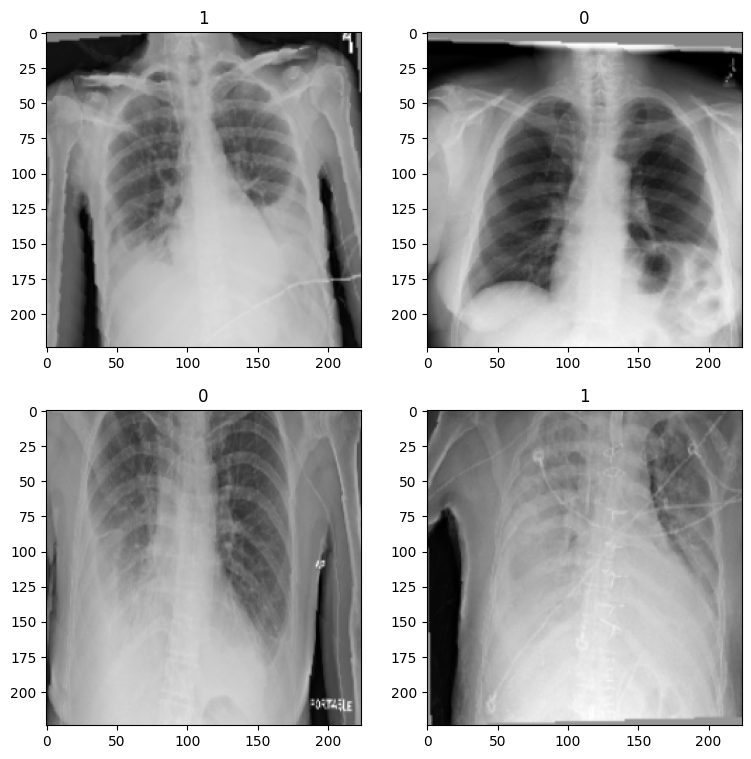

In [7]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))

for i in range(2):
  for j in range(2):
    random_ind = np.random.randint(0, 24000)
    x_ray, label = train_dataset[random_ind]
    print(x_ray.shape)
    axis[i][j].imshow(x_ray[0], cmap="gray")
    axis[i][j].set_title(label)

In [8]:
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)


In [9]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
class PneumoniaModel(torch.nn.Module):
  def __init__(self):
    super(PneumoniaModel, self).__init__()
    self.model = torchvision.models.resnet18()

    self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=True)
    self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)


  def forward(self, x):
    return self.model(x)


In [11]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [12]:
model = PneumoniaModel().to(device)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
def calculate_accuracy(outputs, labels):
    # Convert outputs to predictions: 1 if output >= 0.5, 0 otherwise
    preds = outputs >= 0.5
    correct = (preds == labels.byte()).float()  # Convert to float for division
    accuracy = correct.sum() / len(correct)
    return accuracy

In [14]:
for epoch in range(35):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        outputs = outputs.to(device)

        loss = criterion(outputs.squeeze(), labels.float())  # Adjust the output shape if necessary
        accuracy = calculate_accuracy(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy.item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Inference mode, no need to calculate gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = outputs.to(device)
            loss = criterion(outputs.squeeze(), labels.float())
            accuracy = calculate_accuracy(outputs.squeeze(), labels)

            val_running_loss += loss.item()
            val_running_accuracy += accuracy.item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_running_accuracy / len(val_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

print('Finished Training')


  0%|          | 0/376 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
model_save_path = 'models/pneumonia_classification_RESNET34.pth'
torch.save(model.state_dict(), model_save_path)

In [ ]:
model.load_state_dict(torch.load('models/pneumonia_classification_RESNET34.pth'))

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation for efficiency
with torch.no_grad():
    for inputs, labels in val_loader:
        # Assuming your model and data are on the same device (CPU or CUDA)
        # Move inputs to the same device as your model if necessary
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Convert outputs to probabilities and get the predicted class
        _, preds = torch.max(outputs, 1)

        # Collect the predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Assuming you have a list of class names in the variable 'class_names'
# Plot the confusion matrix
plot_confusion_matrix(cm, classes=[0, 1], title='Confusion Matrix')

plt.show()

In [ ]:
def calculate_metrics(cm):
    # Accuracy
    accuracy = np.trace(cm) / np.sum(cm).astype('float')

    # Precision per class
    precision = np.diag(cm) / np.sum(cm, axis=0).astype('float')

    # Recall per class
    recall = np.diag(cm) / np.sum(cm, axis=1).astype('float')

    # Mean Precision and Recall
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)

    # Print the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (per class): {precision}")
    print(f"Recall (per class): {recall}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")

In [ ]:
calculate_metrics(cm)